In [ ]:
!pip install torch torchvision timm einops


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.7 MB/s eta 0:00:00


In [ ]:
# Install the official microsoft CSWin github repo to access the model files

!git clone https://github.com/microsoft/CSWin-Transformer.git

Cloning into 'CSWin-Transformer'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 74 (delta 16), reused 11 (delta 11), pack-reused 54 (from 1)
Receiving objects: 100% (74/74), 4.51 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
import os
os.chdir('/content/CSWin-Transformer')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')|

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from typing import Tuple
import random
from PIL import Image
import torch.nn as nn
from models.cswin import CSWinTransformer
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data loader class that applies data augmentation, change to grayscale and normalize all images in the dataset 1
class CovidDataloader:
    def __init__(self):
        dataset = "Pre_Train"
        self.train_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Train"
        self.val_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Val"
        self.test_dir = f"/content/drive/MyDrive/new_dataset/{dataset}/Test"

        def grayscale_to_rgb(image):
            return Image.merge('RGB', (image, image, image))

        self.train_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((224, 224)),
            transforms.Lambda(grayscale_to_rgb),  # USe grayscale values for all 3 channels for train set images

            # Apply data augmentation Random Horizontal and Vetrical Filp, Rotation by 15 degress, translation, scale, shear and normalize the images only in train set
            transforms.RandomApply([
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
                transforms.RandomAffine(degrees=0, shear=10)
            ], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.val_test_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((224, 224)),
            transforms.Lambda(grayscale_to_rgb),  # Use grayscale values for all 3 channels for test and validation sets
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.train_dataset = datasets.ImageFolder(root=self.train_dir, transform=self.train_transform)
        self.val_dataset = datasets.ImageFolder(root=self.val_dir, transform=self.val_test_transform)
        self.test_dataset = datasets.ImageFolder(root=self.test_dir, transform=self.val_test_transform)

    def get_loaders(self, batch_size: int = 32, num_workers: int = 2):
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

        return train_loader, val_loader, test_loader


dataloader = CovidDataloader()
train_loader, val_loader, test_loader = dataloader.get_loaders(batch_size=64)


print(f"Length of training dataset: {len(dataloader.train_dataset)}")
print(f"Length of validation dataset: {len(dataloader.val_dataset)}")
print(f"Length of test dataset: {len(dataloader.test_dataset)}")


Length of training dataset: 3840
Length of validation dataset: 956
Length of test dataset: 1199


In [ ]:
def create_cswin_model(model_type='small', num_classes=1000):
    if model_type == 'tiny':
        model = CSWinTransformer(patch_size=4, embed_dim=64, depth=[1,2,21,1],
                                 split_size=[1,2,7,7], num_heads=[2,4,8,16], mlp_ratio=4.)
    elif model_type == 'small':
        model = CSWinTransformer(patch_size=4, embed_dim=64, depth=[2,4,32,2],
                                 split_size=[1,2,7,7], num_heads=[2,4,8,16], mlp_ratio=4.)
    elif model_type == 'base':
        model = CSWinTransformer(patch_size=4, embed_dim=96, depth=[2,4,32,2],
                                 split_size=[1,2,7,7], num_heads=[4,8,16,32], mlp_ratio=4.)
    elif model_type == 'large':
        model = CSWinTransformer(patch_size=4, embed_dim=144, depth=[2,4,32,2],
                                 split_size=[1,2,7,7], num_heads=[6,12,24,24], mlp_ratio=4.)
    else:
        raise ValueError("Invalid model type. OPtions 'tiny', 'small', 'base', or 'large'.")

    return model

#  Initialize the CSWin model from the cloned repo
model = create_cswin_model(model_type='small', num_classes=1000)

# Load the imagenet weights
checkpoint = torch.load('/content/drive/MyDrive/CSwin/cswin_imagenet1k.pth', map_location='cpu')
model.load_state_dict(checkpoint['state_dict_ema'])


num_features = model.head.in_features
model.head = nn.Linear(num_features, 3)

# Set all the parameters to be trained
for param in model.parameters():
    param.requires_grad = True
model.head.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-7-5803179c81ca>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/CSwin/cswin_small_224.pth', map_location='cp

In [ ]:
criterion = torch.nn.CrossEntropyLoss()


# Use the learning rate and weight decay used by the model for its imagenet fine-tuning
optimizer = optim.AdamW(model.parameters(), lr=1e-5,weight_decay=1e-8)

writer = SummaryWriter()


num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.max(outputs, 1)[1]
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = torch.max(outputs, 1)[1]
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)

    writer.add_scalars('Loss', {'train': epoch_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'train': epoch_acc, 'val': val_acc}, epoch)

    print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

writer.close()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0/9, Train Loss: 0.9356, Train Acc: 0.5810, Val Loss: 0.6433, Val Acc: 0.7071
Epoch 1/9, Train Loss: 0.6649, Train Acc: 0.7393, Val Loss: 0.4737, Val Acc: 0.7521
Epoch 2/9, Train Loss: 0.5081, Train Acc: 0.8010, Val Loss: 0.3620, Val Acc: 0.7981
Epoch 3/9, Train Loss: 0.4268, Train Acc: 0.8331, Val Loss: 0.3211, Val Acc: 0.8190
Epoch 4/9, Train Loss: 0.3602, Train Acc: 0.8583, Val Loss: 0.2763, Val Acc: 0.8337
Epoch 5/9, Train Loss: 0.3213, Train Acc: 0.8745, Val Loss: 0.2853, Val Acc: 0.8264
Epoch 6/9, Train Loss: 0.3040, Train Acc: 0.8846, Val Loss: 0.2397, Val Acc: 0.8504
Epoch 7/9, Train Loss: 0.2750, Train Acc: 0.8951, Val Loss: 0.2344, Val Acc: 0.8525
Epoch 8/9, Train Loss: 0.2560, Train Acc: 0.9005, Val Loss: 0.2310, Val Acc: 0.8504
Epoch 9/9, Train Loss: 0.2384, Train Acc: 0.9086, Val Loss: 0.2320, Val Acc: 0.8567


In [ ]:
# Evaluate the trained model on the test set

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.max(outputs, 1)[1]
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Compute Evaluation Metrics and confusion matrix

test_acc = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_acc:.4f}')

f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score: {f1:.4f}')

class_names = ['COVID-19', 'Non-COVID', 'Normal']

class_report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:')
print(class_report)

conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


<pre>
Test Accuracy: 0.9245
F1 Score: 0.9251
Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.93      0.95       423
   Non-COVID       0.93      0.92      0.92       398
       COVID       0.86      0.93      0.89       331

    accuracy                           0.92      1152
   macro avg       0.92      0.92      0.92      1152
weighted avg       0.93      0.92      0.93      1152

</pre>

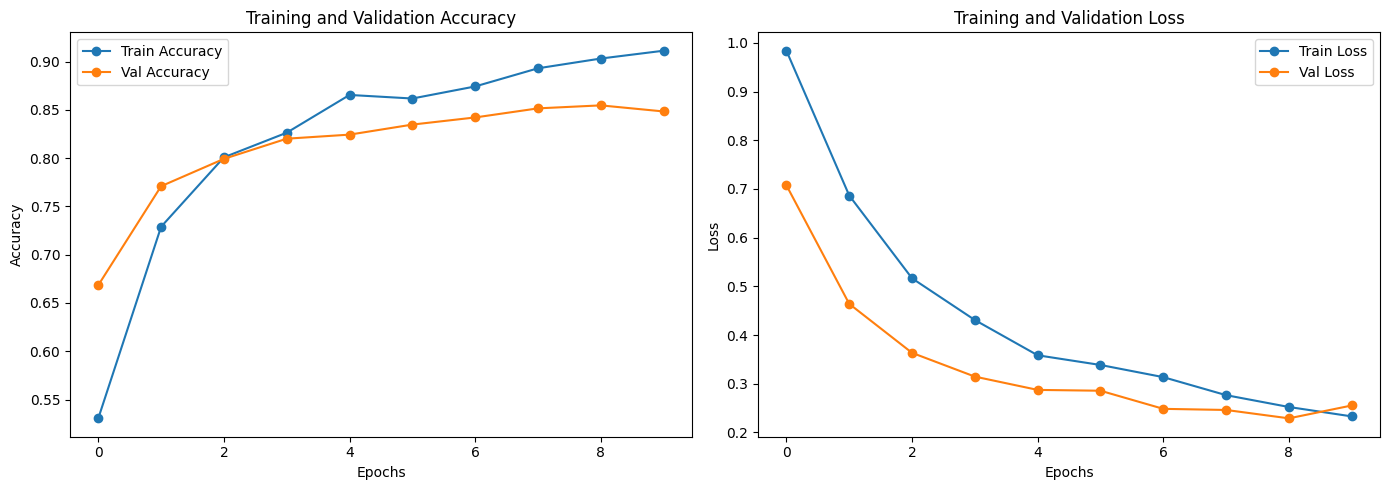

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation - loss and accuracy graphs

epochs = list(range(10))
train_loss = [0.9839, 0.6865, 0.5165, 0.4308, 0.3584, 0.3385, 0.3135, 0.2765, 0.2522, 0.2329]
train_acc = [0.5305, 0.7289, 0.8008, 0.8263, 0.8654, 0.8617, 0.8742, 0.8930, 0.9031, 0.9112]
val_loss = [0.7075, 0.4640, 0.3634, 0.3146, 0.2873, 0.2856, 0.2484, 0.2461, 0.2289, 0.2553]
val_acc = [0.6684, 0.7709, 0.7992, 0.8201, 0.8243, 0.8347, 0.8421, 0.8515, 0.8546, 0.8483]


plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSwin/cswin_d1_encoder.pth')